# Fourier Transform
Fourier Transform is one of the techniques used to process images. This notebook aims to find out the usage of our Unet model.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from google.colab.patches import cv2_imshow
from typing import List

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/MachineLearning/Geospatial_ML

/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML


In [ ]:
! git pull
! git checkout feature/fourier-transform

In [4]:
data_directory = "../data_colab/256_200"

x_train  = np.load(os.path.join(data_directory, '2022_06_20.npz'))['x_input']

### Transform Images into Magnitude Spectrum
The Magnitude Spectrum refers to the size of amplitude of each frequency components.

For visualisation purposes, it is often useful to have the low-frequency components at the centre of the image. So, this notebook shifts the low-frequencies to the centre.

In [74]:
def generate_magnitude_spectrum(image_arr: np.ndarray)->List[np.ndarray]:
  is_four_dimentional = len(image_arr.shape) == 4
  magnitude_spectrums=[None]*len(image_arr)

  if not is_four_dimentional:
    raise ValueError("Input array must have [collection_num, row, column, channels]")

  for i, img in enumerate(image_arr):
    rgb_img = img[:, :, :3]
    rgb_img = cv2.convertScaleAbs(rgb_img)
    # Calculate the magnitude spectrum for each color channel
    f_r = np.fft.fft2(img[:,:,0])
    f_g = np.fft.fft2(img[:,:,1])
    f_b = np.fft.fft2(img[:,:,2])
    mag_r = 20*np.log(np.abs(np.fft.fftshift(f_r)))
    mag_g = 20*np.log(np.abs(np.fft.fftshift(f_g)))
    mag_b = 20*np.log(np.abs(np.fft.fftshift(f_b)))
    # Combine the magnitude spectra into a single grayscale image
    magnitude_spectrum = cv2.merge((mag_r, mag_g, mag_b))
    magnitude_spectrum = np.max(magnitude_spectrum, axis=2)
    magnitude_spectrums[i] = magnitude_spectrum
  return magnitude_spectrums

In [8]:
def extract_rgb(image_arr: np.ndarray)->List[np.ndarray]:
  rgbs =[None]*len(image_arr)
  for i, img in enumerate(image_arr):
    rgb = img[:, :, :3]
    rgb = cv2.convertScaleAbs(rgb)
    rgbs[i] = rgb
  return rgbs

In [53]:
def display_image(display_list: List[np.ndarray], title_list: List[str]):
    num_images = len(display_list[0])
    num_plots = num_images * 2
    plt.figure(figsize=(15, 15))
    
    for i in range(num_plots):
        plt.subplot(2, num_images, i + 1)
        if i % 2 == 0:
            plt.imshow(display_list[0][i//2])
        else:
            plt.imshow(display_list[1][i//2], cmap='gray')
        plt.title(title_list[i//2])
    
    plt.show()

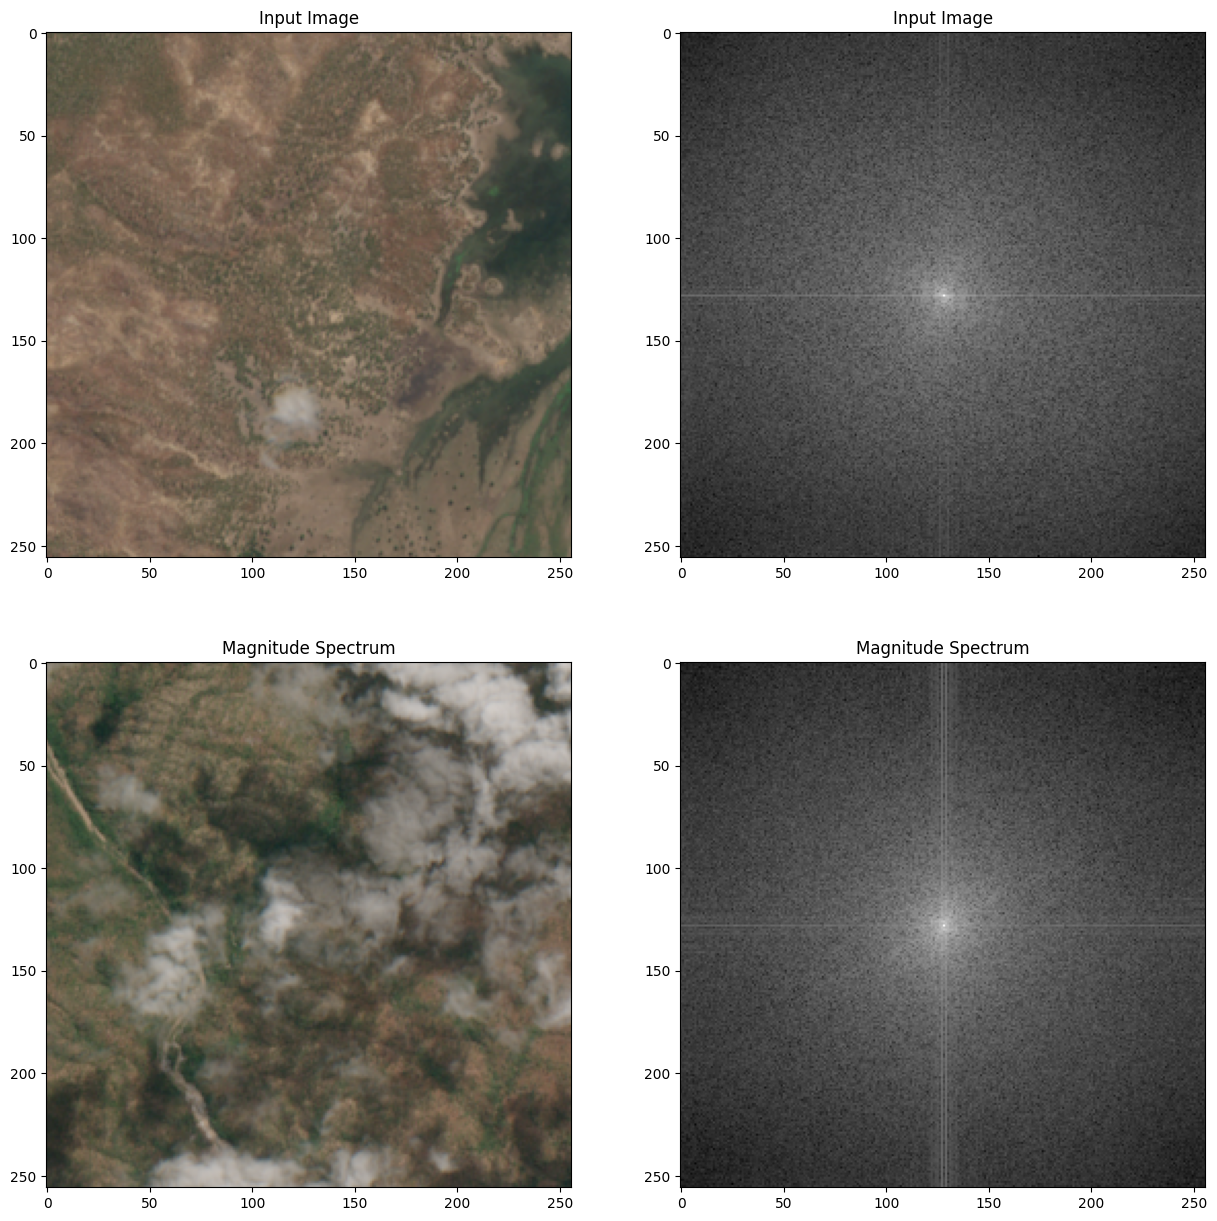

In [99]:
rgbs =extract_rgb(x_train[:2])
magnitude_spectrum = generate_magnitude_spectrum(x_train[:2])
display_list = [rgbs, magnitude_spectrum]
display_image(display_list, ["Input Image", "Magnitude Spectrum"])

### Edge Detection

The Fourier Transform assumes that low-frequency components represents the average intensity or brightness of the image. So, for instance, if you remove low-frequency components from images (high-pass filtered images: HPF), you can detect edges of the images and might compress the images.

In [41]:
def generate_hpf_images(rgb_imgs: np.ndarray)->List[np.ndarray]:
  hpf_images = [None]*len(rgb_imgs)
  for i, img in enumerate(rgb_imgs):
    is_rgb = img.shape[-1]
    if not is_rgb:
      raise ValueError("Input array should contain RGB images")
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply Fourier transform to image
    f = np.fft.fft2(grey_img)

    # # Shift zero frequency component to center
    fshift = np.fft.fftshift(f)

    # # Set low frequency coefficients to zero
    rows, cols = grey_img.shape
    crow, ccol = rows/2, cols/2
    crow = int(crow)
    ccol = int(ccol)
    fshift[crow-30:crow+30, ccol-30:ccol+30] = 0

    # Shift zero frequency component back to origin
    f_ishift = np.fft.ifftshift(fshift)
    # Invert Fourier transform to obtain filtered image
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_back = img_back.astype(np.uint8)
    hpf_images[i] = img_back
  return hpf_images


In [42]:
rgbs =extract_rgb(x_train[:2])
print(rgbs[0].shape[-1])
print(rgbs[1].shape)
# hpf_images = generate_hpf_images(rgbs)
# print(hpf_images)
# print(x_train.shape)
# print(x_train[0].shape)

3
(256, 256, 3)


In [43]:
hpf_images = generate_hpf_images(rgbs)

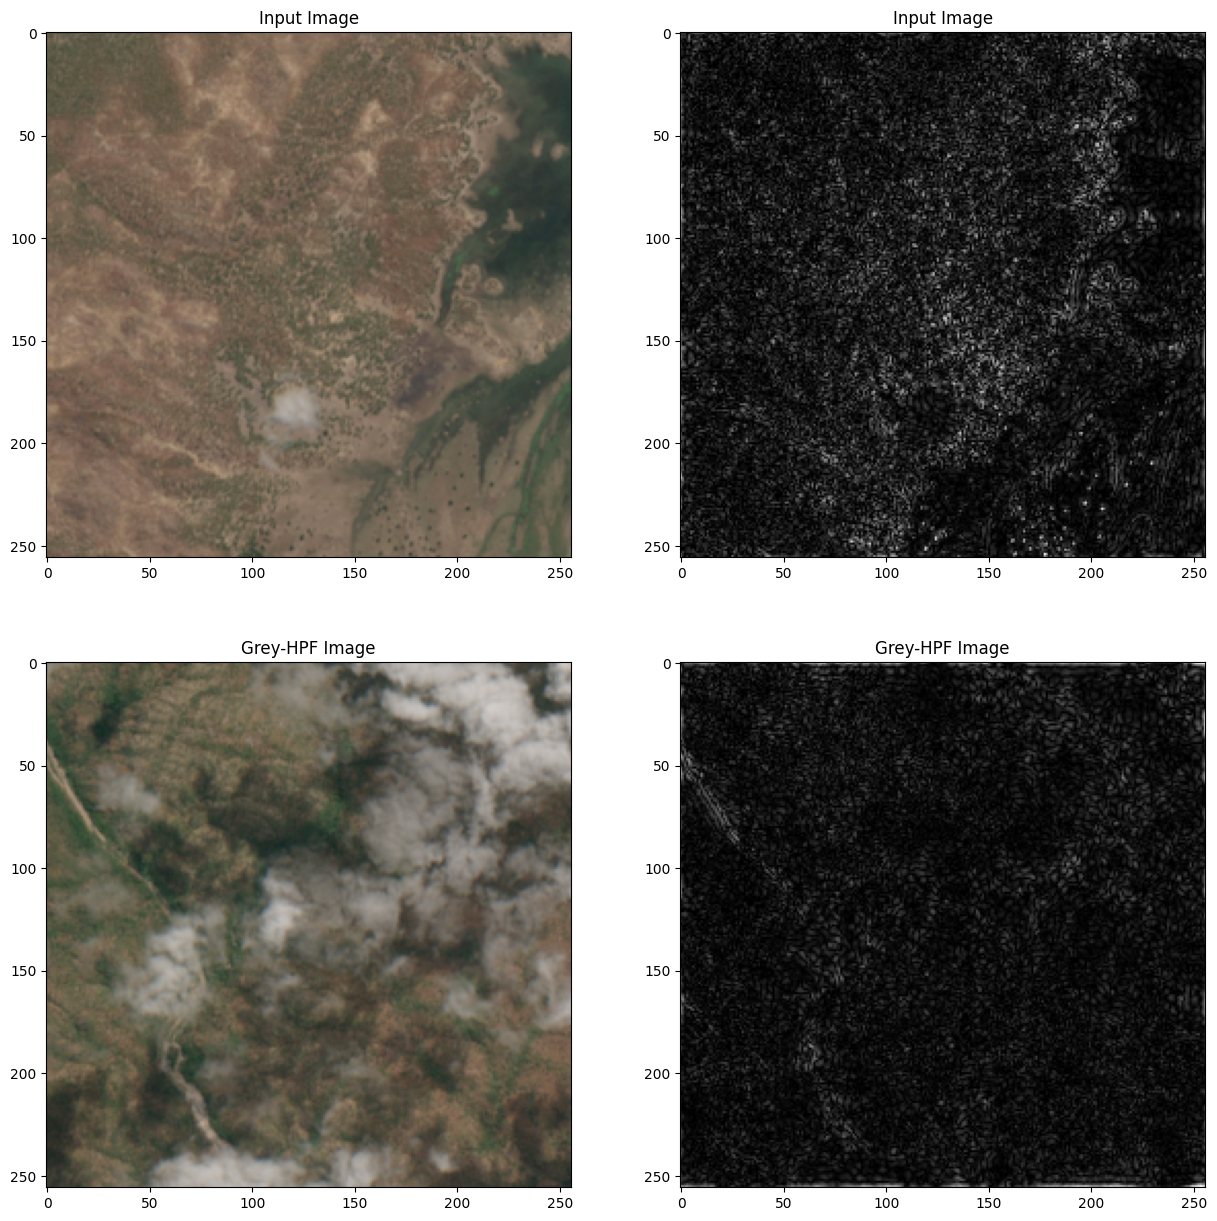

In [54]:
rgbs =extract_rgb(x_train[:2])
hpf_images = generate_hpf_images(rgbs)
display_list = [rgbs, hpf_images]
display_image(display_list, ["Input Image", "Grey-HPF Image"])

In [84]:
class Fourier:
  __slots__= [
      "input_arr",
      "__rgb_arr"
  ]

  def __init__(self, input_arr:  List[np.ndarray]):
    self.input_arr = input_arr
    self.__rgb_arr = self.__extract_rgb(self.input_arr)

  def __extract_rgb(self,image_arr: List[np.ndarray])->List[np.ndarray]:
    is_four_dimentional = len(image_arr.shape) == 4

    if not is_four_dimentional:
      raise ValueError("Input array must have [collection_num, row, column, channels]")

    rgbs =[None]*len(image_arr)
    for i, img in enumerate(image_arr):
      rgb = img[:, :, :3]
      rgb = cv2.convertScaleAbs(rgb)
      rgbs[i] = rgb
    return rgbs

  def get_rgb_images(self):
    return self.__rgb_arr
  
  def generate_magnitude_spectrum(self)->List[np.ndarray]:
    magnitude_spectrums=[None]*len(self.__rgb_arr)

    for i, img in enumerate(self.__rgb_arr):
      # Calculate the magnitude spectrum for each color channel
      f_r = np.fft.fft2(img[:,:,0])
      f_g = np.fft.fft2(img[:,:,1])
      f_b = np.fft.fft2(img[:,:,2])
      mag_r = 20*np.log(np.abs(np.fft.fftshift(f_r)))
      mag_g = 20*np.log(np.abs(np.fft.fftshift(f_g)))
      mag_b = 20*np.log(np.abs(np.fft.fftshift(f_b)))
      # Combine the magnitude spectra into a single grayscale image
      magnitude_spectrum = cv2.merge((mag_r, mag_g, mag_b))
      magnitude_spectrum = np.max(magnitude_spectrum, axis=2)
      magnitude_spectrums[i] = magnitude_spectrum
    return magnitude_spectrums

  def generate_hpf_images(self)->List[np.ndarray]:
    hpf_images = [None]*len(self.__rgb_arr)

    for i, img in enumerate(self.__rgb_arr):
      gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      # Apply Fourier transform to image
      f = np.fft.fft2(gray_img)

      # # Shift zero frequency component to center
      fshift = np.fft.fftshift(f)

      # # Set low frequency coefficients to zero
      rows, cols = gray_img.shape
      crow, ccol = rows/2, cols/2
      crow = int(crow)
      ccol = int(ccol)
      fshift[crow-30:crow+30, ccol-30:ccol+30] = 0

      # Shift zero frequency component back to origin
      f_ishift = np.fft.ifftshift(fshift)
      # Invert Fourier transform to obtain filtered image
      img_back = np.fft.ifft2(f_ishift)
      img_back = np.abs(img_back)
      img_back = img_back.astype(np.uint8)
      hpf_images[i] = img_back
    return hpf_images
  

In [85]:
part_x_train = x_train[:2]
fouriers = Fourier(part_x_train)
rgb_images = fouriers.get_rgb_images()
magnitude_spectrums = fouriers.generate_magnitude_spectrum()
hpfs = fouriers.generate_hpf_images()

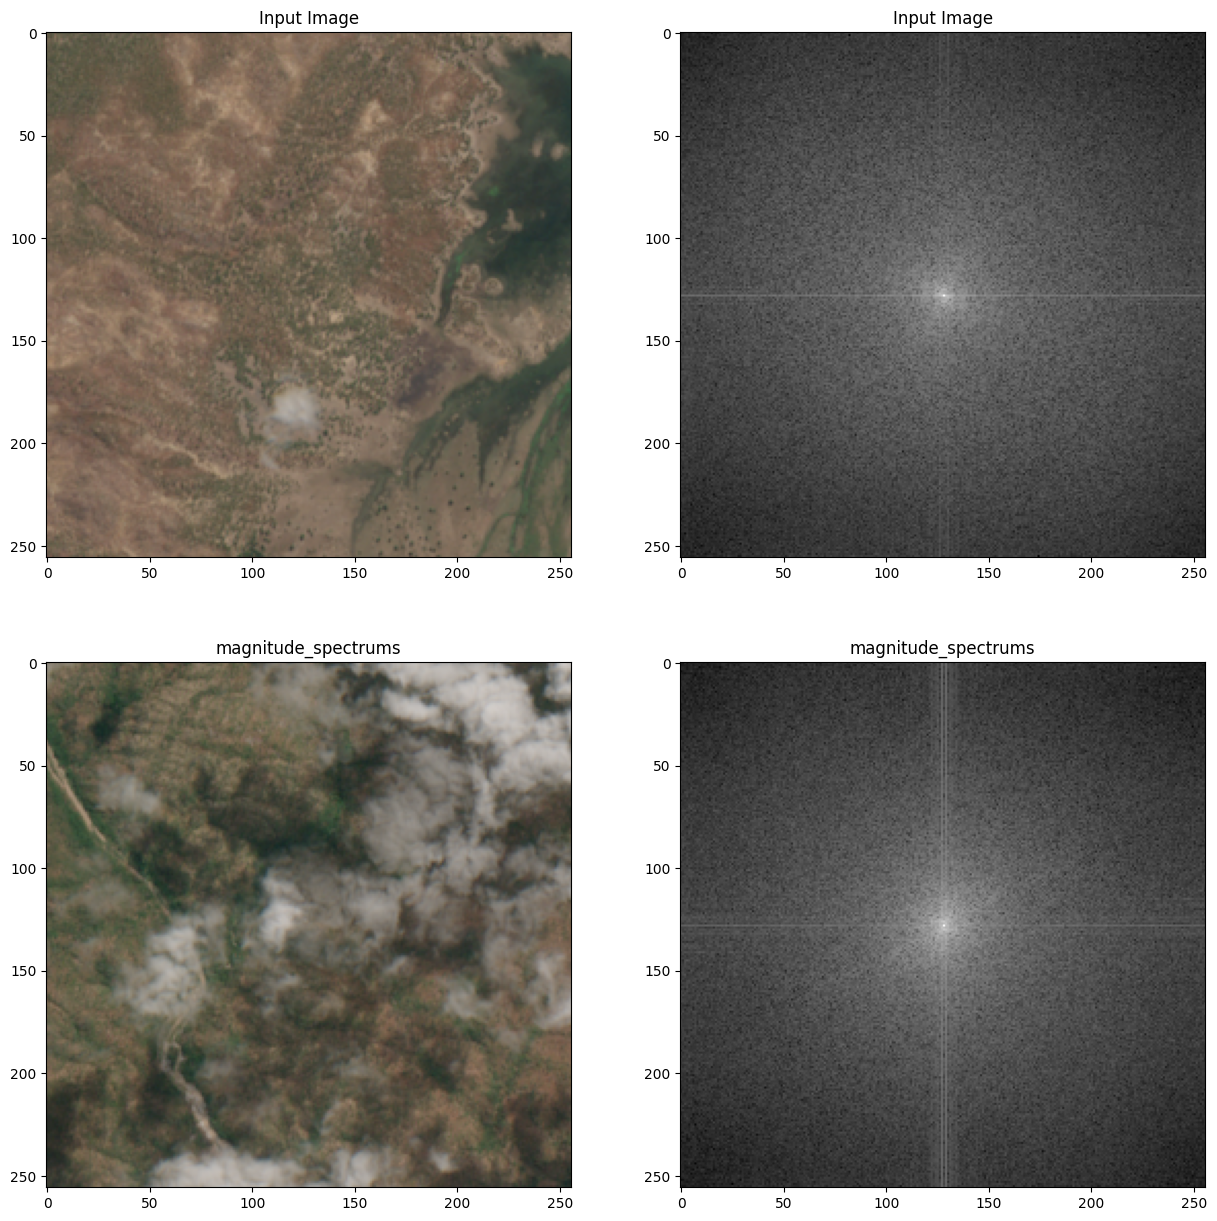

In [86]:
display_list = [rgb_images, magnitude_spectrums]
display_image(display_list, ["Input Image", "magnitude_spectrums"])

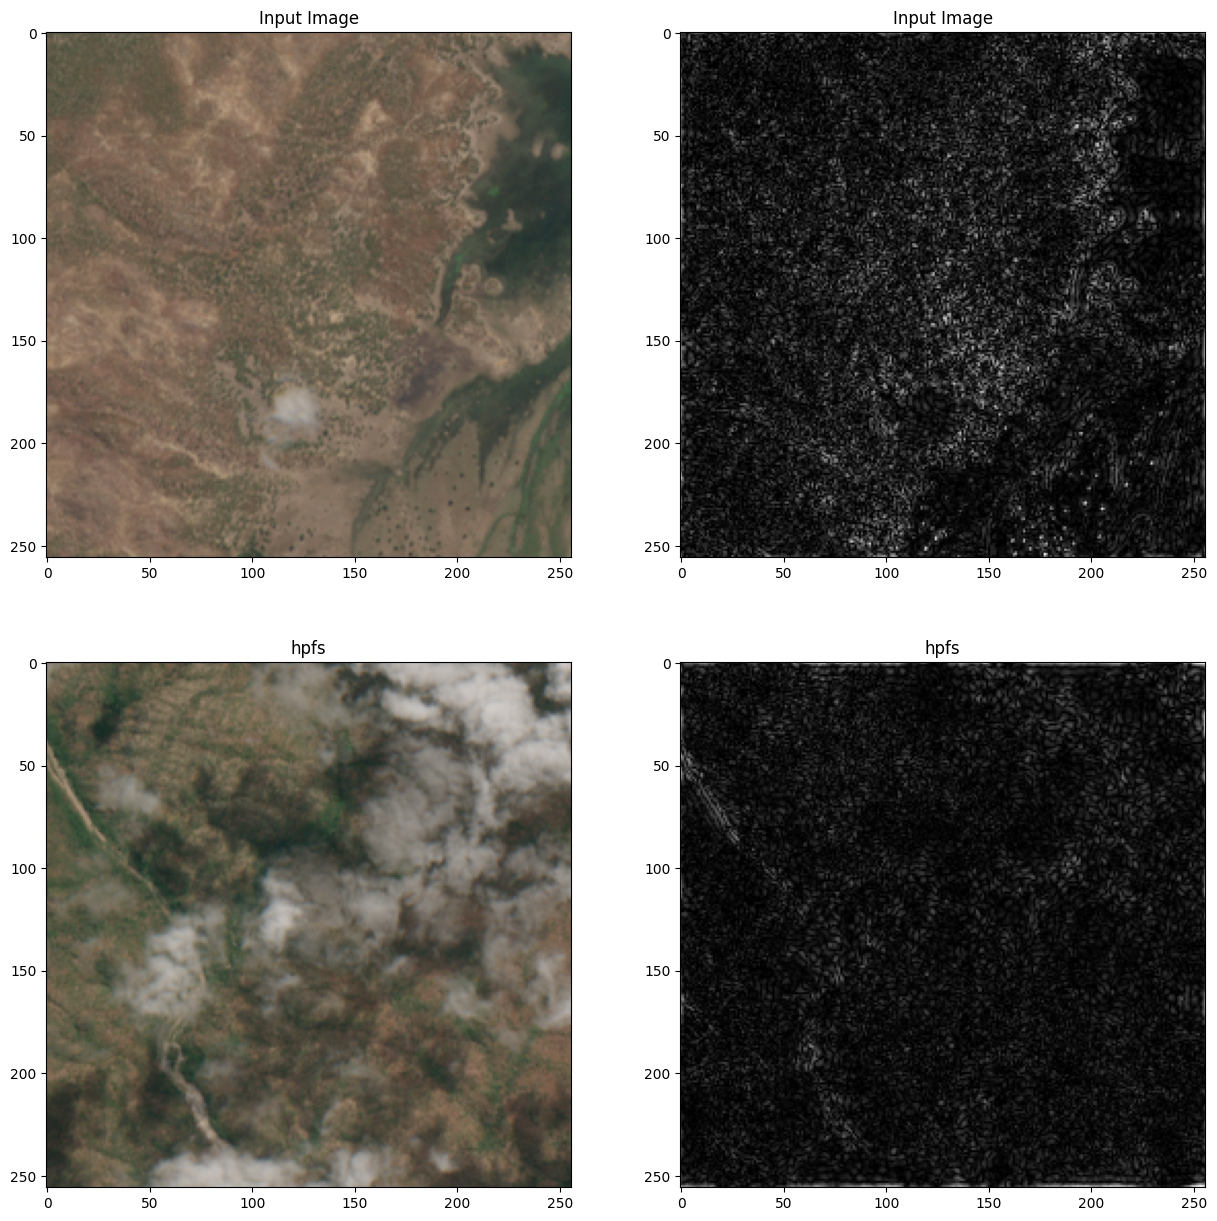

In [87]:
display_list = [rgb_images, hpfs]
display_image(display_list, ["Input Image", "hpfs"])